probably don't need 

In [1]:
# not all imports are actually used

# built in python modules
import datetime
import os
import sys
import glob
import itertools
from collections import OrderedDict
from importlib import reload

# python add-ons
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib as mpl
import seaborn as sns
sns.set(style='whitegrid', rc={'figure.figsize':(12, 6)})

import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment', 'raise')

import xarray as xr
import numexpr as ne

In [25]:
# For 4/15
dataset = xr.open_dataset('/a2/uaren/2014/04/15/solar_3/wrfsolar_d02_hourly.nc')

In [40]:
# For 5/29
dataset = xr.open_dataset('/a2/uaren/2014/05/29/solar_3/wrfsolar_d02_hourly.nc')

In [6]:
dataset.attrs

OrderedDict([('TITLE', ' OUTPUT FROM WRF V3.5.1 MODEL'),
             ('START_DATE', '2014-05-29_12:00:00'),
             ('SIMULATION_START_DATE', '2014-05-29_12:00:00'),
             ('WEST-EAST_GRID_DIMENSION', 430),
             ('SOUTH-NORTH_GRID_DIMENSION', 352),
             ('BOTTOM-TOP_GRID_DIMENSION', 38),
             ('DX', 1800.0),
             ('DY', 1800.0),
             ('STOCH_FORCE_OPT', 0),
             ('GRIDTYPE', 'C'),
             ('DIFF_OPT', 1),
             ('KM_OPT', 4),
             ('DAMP_OPT', 3),
             ('DAMPCOEF', 0.15000001),
             ('KHDIF', 300.0),
             ('KVDIF', 1.0),
             ('MP_PHYSICS', 10),
             ('RA_LW_PHYSICS', 4),
             ('RA_SW_PHYSICS', 4),
             ('SF_SFCLAY_PHYSICS', 1),
             ('SF_SURFACE_PHYSICS', 2),
             ('BL_PBL_PHYSICS', 7),
             ('CU_PHYSICS', 0),
             ('SURFACE_INPUT_SOURCE', 1),
             ('SST_UPDATE', 0),
             ('GRID_FDDA', 0),
             

In [4]:
dataset.Times

<xarray.DataArray 'Times' (Time: 49)>
array([b'2014-05-29_12:00:00', b'2014-05-29_13:00:00', b'2014-05-29_14:00:00',
       b'2014-05-29_15:00:00', b'2014-05-29_16:00:00', b'2014-05-29_17:00:00',
       b'2014-05-29_18:00:00', b'2014-05-29_19:00:00', b'2014-05-29_20:00:00',
       b'2014-05-29_21:00:00', b'2014-05-29_22:00:00', b'2014-05-29_23:00:00',
       b'2014-05-30_00:00:00', b'2014-05-30_01:00:00', b'2014-05-30_02:00:00',
       b'2014-05-30_03:00:00', b'2014-05-30_04:00:00', b'2014-05-30_05:00:00',
       b'2014-05-30_06:00:00', b'2014-05-30_07:00:00', b'2014-05-30_08:00:00',
       b'2014-05-30_09:00:00', b'2014-05-30_10:00:00', b'2014-05-30_11:00:00',
       b'2014-05-30_12:00:00', b'2014-05-30_13:00:00', b'2014-05-30_14:00:00',
       b'2014-05-30_15:00:00', b'2014-05-30_16:00:00', b'2014-05-30_17:00:00',
       b'2014-05-30_18:00:00', b'2014-05-30_19:00:00', b'2014-05-30_20:00:00',
       b'2014-05-30_21:00:00', b'2014-05-30_22:00:00', b'2014-05-30_23:00:00',
       b'2014-

In [3]:
def rh_calc(temps, pressure, qvapor):
    """
    Actually calculate rh from arrays
    """
    T1 = 273.16
    # Groff-Gratch equation
    ew = 10**(10.78574 * (1 - T1/temps)+
         - 5.028 * np.log10(temps/T1)+
         + 1.50475*10**-4 * (1 - 10**(-8.2969 * (temps/T1 - 1)))+
         + 0.42873*10**-3 * (10**(4.76955 * (1 - T1/temps)) - 1)+
         + 0.78614)
    # Bolton Equation
    #ew = ne.evaluate('6.112*exp(17.62*(temps-273.15)/(243.21 + temps - 273.15))')

    es = ew*(1.0016+3.15*10**-6*pressure-0.074/pressure)

    e = qvapor/(qvapor+0.62198)*pressure
    rh = e/es*100
    return rh

def dewpoint_calc(qvapor, pressure):
    """
    Actually calculate tdew from arrays
    """
    e = qvapor/(qvapor+0.62198)*pressure
    # Bolton's fit
    a = 6.112 #millibars
    b = 17.67
    c = 243.5 #deg C
    logterm = np.log(e/a)
    tdew = (c*logterm)/(b-logterm)
    return tdew

In [41]:
dataset = dataset.isel(Time=slice(5, 12))

In [42]:
dataset['pressure'] = dataset['P'] + dataset['PB']
dataset['temp'] = (dataset['T']+300)*(dataset['pressure']/100000)**0.2854
dataset['rh'] = rh_calc(dataset['temp'], dataset['pressure']/100, dataset['QVAPOR'])

In [43]:
dims = list(dataset['rh'].dims)
dims.remove('Time')
dims.remove('bottom_top')
dataset['average_rh'] = dataset['rh'].mean(dim=dims)

In [44]:
data_Times = dataset['Times'].to_pandas().apply(
    lambda x: pd.to_datetime(x.decode("utf-8").replace('_', ' ')))
data_Times = pd.Index(data_Times).tz_localize('UTC').tz_convert('MST')

In [45]:
# num_of_times = (Times <= 
#                 pd.to_datetime('2014-04-15 20:00:00').tz_localize('MST')).sum()
# Times = Times[slice(0, num_of_times)]
# start = pd.to_datetime('2014-05-29 08:00:00').tz_localize('MST')
# end = pd.to_datetime('2014-05-29 17:00:00').tz_localize('MST')
# Times = data_Times[(data_Times >= start) & (data_Times <= end)]
Times = data_Times
Times_int = dataset.Time.values
# Times_int = Times_int[(data_Times >= start) & (data_Times <= end)]
num_of_times = Times.size

temp = dataset.sel(Time=Times_int[0])
bottom_top = pd.Series()
bottom_top[Times[0]] = temp['bottom_top'].where(
    temp['average_rh'] == temp['average_rh'].max(), drop=True).item()

In [46]:
for t in np.arange(num_of_times - 1) + 1:
    temp = dataset.isel(Time=t)
    bottom_top[Times[t]] = temp['bottom_top'].where(
        temp['average_rh'] == temp['average_rh'].max(), drop=True).item()
    

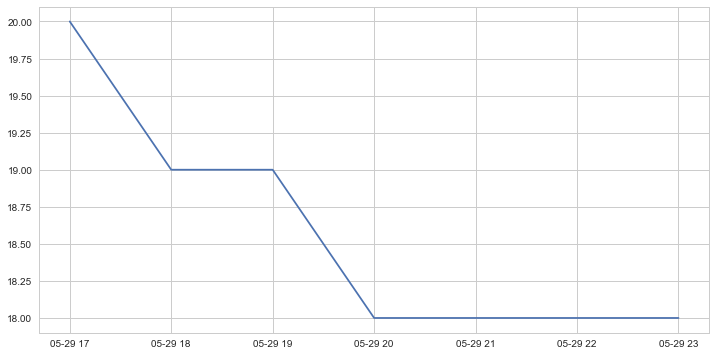

In [47]:
#5/29
plt.figure()
plt.plot(bottom_top)

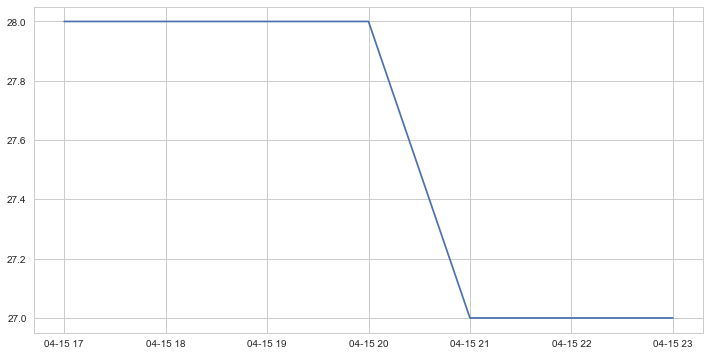

In [39]:
#4/15
plt.figure()
plt.plot(bottom_top)

In [9]:
# num_of_times = (Times <= 
#                 pd.to_datetime('2014-04-15 20:00:00').tz_localize('MST')).sum()
# Times = Times[slice(0, num_of_times)]
start = pd.to_datetime('2014-05-29 08:00:00').tz_localize('MST')
end = pd.to_datetime('2014-05-29 17:00:00').tz_localize('MST')
Times = data_Times[(data_Times >= start) & (data_Times <= end)]
Times_int = dataset.Time.values
Times_int = Times_int[(data_Times >= start) & (data_Times <= end)]
num_of_times = Times.size

temp = dataset.sel(Time=Times_int[0])
bottom_top = pd.Series()
bottom_top[Times[0]] = temp['bottom_top'].where(
    temp['average_rh'] == temp['average_rh'].max(), drop=True).item()
U = pd.DataFrame(
    data=temp['U'].sel(bottom_top = bottom_top[Times[0]]).values.ravel()[None, :],
    index=[Times[0]])
V = pd.DataFrame(
    data=temp['V'].sel(bottom_top = bottom_top[Times[0]]).values.ravel()[None, :],
    index=[Times[0]])

IndexError: index 0 is out of bounds for axis 0 with size 0

In [45]:
for t in np.arange(num_of_times - 1) + 1:
    temp = dataset.isel(Time=t)
    bottom_top[Times[t]] = temp['bottom_top'].where(
        temp['average_rh'] == temp['average_rh'].max(), drop=True).item()
    U_temp = pd.DataFrame(
        data=temp['U'].sel(bottom_top = bottom_top[Times[t]]).values.ravel()[None, :],
        index=[Times[t]])
    V_temp = pd.DataFrame(
        data=temp['V'].sel(bottom_top = bottom_top[Times[t]]).values.ravel()[None, :],
        index=[Times[t]])
    U = U.append(U_temp)
    V = V.append(V_temp)

In [82]:
U.to_hdf(file.format(variable='U', suffix=suffix), 'U'+suffix)
V.to_hdf(file.format(variable='V', suffix=suffix), 'V'+suffix)
bottom_top.to_hdf(
    file.format(variable='bottom_top', suffix=suffix), 'bottom_top'+suffix)
np.save(file.format(variable='wind_lats', suffix=suffix)[:-3],
        wind_lats)
np.save(file.format(variable='wind_lons', suffix=suffix)[:-3],
        wind_lons)

In [83]:
np.save(file.format(variable='U_shape', suffix=suffix)[:-3],
        U_shape)
np.save(file.format(variable='V_shape', suffix=suffix)[:-3],
        V_shape)

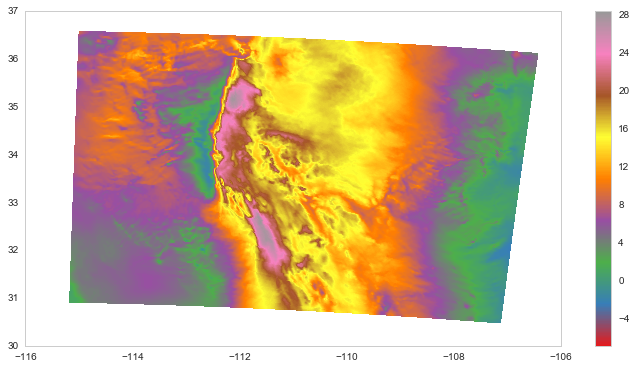

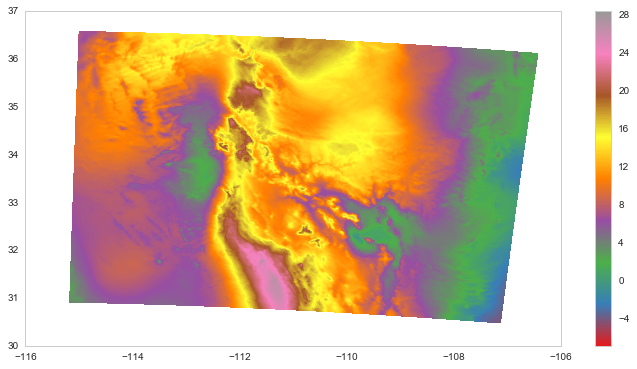

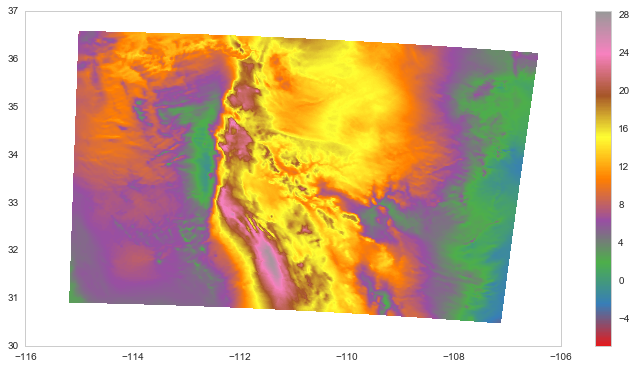

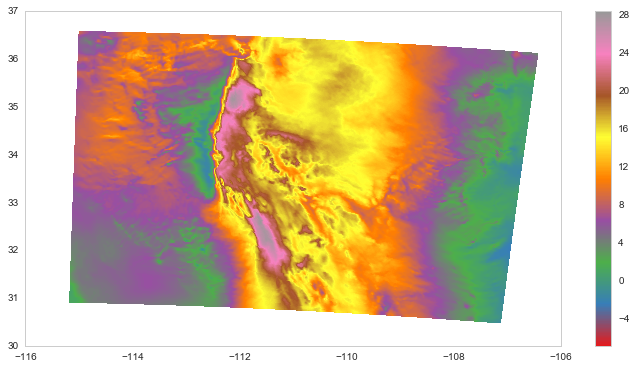

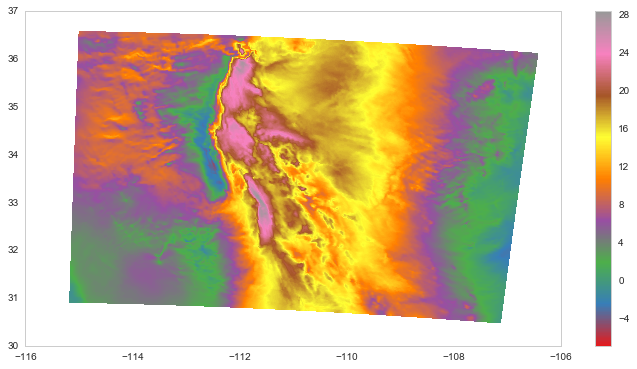

In [87]:
for t in range(5):
#     plt.figure()
#     im = plt.pcolormesh(
#         wind_lons.reshape(U_shape[0], V_shape[1]),
#         wind_lats.reshape(U_shape[0], V_shape[1]),
#         U.iloc[t].values.reshape(U_shape)[:, 1:])
#     plt.colorbar(im)
    vmin = V.values.min()
    vmax = V.values.max()
    plt.figure()
    im = plt.pcolormesh(
        wind_lons.reshape(U_shape[0], V_shape[1]),
        wind_lats.reshape(U_shape[0], V_shape[1]),
        V.iloc[t].values.reshape(V_shape)[1:, :],
        cmap='Set1', vmin=vmin, vmax=vmax)
    plt.colorbar(im)